In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
pickle_in = open("../data/oxygen.pickle", "rb")
oxygen = pickle.load(pickle_in)
oxygen.describe()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,OXYGEN_VALUE
count,1.297000e+04,1.297000e+04,12970.000000,1.297000e+04,1.297000e+04,1.297000e+04,12970.000000
mean,-8.204386e-15,1.314805e-16,0.000000,8.765369e-18,4.908607e-16,4.382685e-15,218.042145
std,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,23.011995
min,-2.068154e+00,-1.740584e+00,-0.035143,-1.160867e+00,-3.063763e+00,-2.152486e+01,109.900000
25%,-7.616786e-01,-8.740841e-01,-0.035143,-6.733490e-01,-7.213280e-01,-4.605411e-01,199.690000
50%,6.971469e-02,3.050335e-02,-0.035143,-1.858306e-01,-1.073420e-01,1.113958e-01,222.920000
75%,7.823375e-01,8.684370e-01,-0.035143,5.454471e-01,6.431659e-01,5.981507e-01,234.980000
max,1.732501e+00,1.725415e+00,28.452813,6.151909e+00,3.317628e+00,3.074516e+00,324.320000


In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/scratch/z3289452/miniconda3/envs/OceanDataScience/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

In [4]:
## Train test split
train_dataset = oxygen.sample(frac=0.8, random_state=0)
test_dataset  = oxygen.drop(train_dataset.index)

In [5]:
train_dataset.head()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,OXYGEN_VALUE
1859,-1.355531,0.563734,-0.035143,0.667327,-0.870289,-0.661327,213.98
6820,0.069715,1.154096,-0.035143,-0.673349,-0.650527,-0.131982,265.80
9274,0.544797,1.239794,-0.035143,0.301688,-0.949072,-0.636990,182.71
11109,0.901108,-0.102804,-0.035143,-0.917108,0.564383,0.214831,227.83
10251,0.782337,-0.569381,-0.035143,6.151909,-2.267644,-2.352801,202.81


In [6]:
train_labels = train_dataset.pop('OXYGEN_VALUE')
test_labels = test_dataset.pop('OXYGEN_VALUE')

### The Model

In [16]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation='relu'),
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
    ])
    
    optimizer = keras.optimizers.Adam()
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [17]:
model = build_model()

In [18]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 5,137
Trainable params: 5,137
Non-trainable params: 0
_________________________________________________________________


In [25]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [26]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,124.105141,8.044875,124.105143,3.772340,133.628096,8.503744,133.628095,3.946359
std,5.019757,0.177361,5.019758,0.083227,4.749098,0.212164,4.749098,0.099593
min,115.998774,7.751125,115.998795,3.634219,125.249854,8.130034,125.249855,3.764160
25%,120.222926,7.905116,120.222910,3.706797,130.151139,8.348971,130.151138,3.875533
50%,122.832589,7.999689,122.832600,3.750814,133.008074,8.473672,133.008087,3.930791
75%,127.342597,8.157766,127.342588,3.824708,136.167953,8.608869,136.167953,4.002208
max,138.215576,8.559223,138.215591,4.012484,165.588207,9.861861,165.588226,4.612249


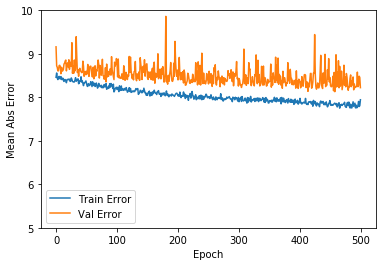

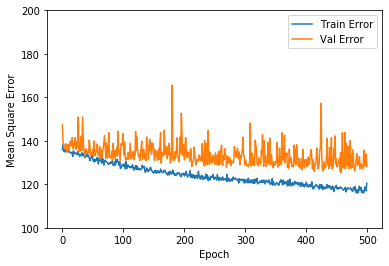

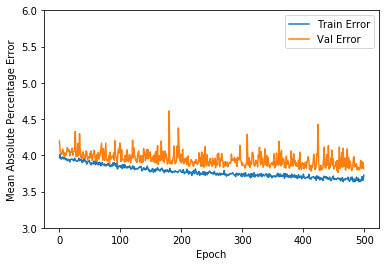

In [39]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([5,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([100,200])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  plt.ylim([3,6])
  plt.legend()
  plt.show()


plot_history(history)

In [33]:
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

2594/2594 - 0s - loss: 138.2379 - mae: 8.3196 - mse: 138.2379 - mean_absolute_percentage_error: 3.9170
Testing set Mean Abs Percentage Error:  3.92


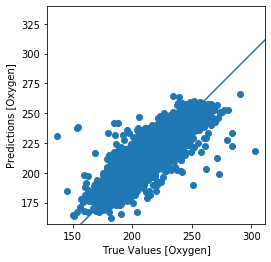

In [32]:
## Make predictions
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Oxygen]')
plt.ylabel('Predictions [Oxygen]')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-300, 500], [-300, 500])

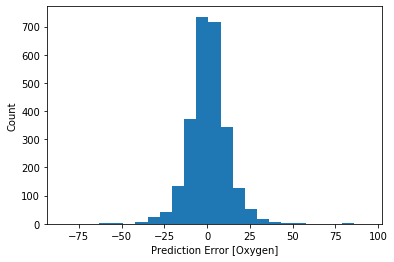

In [22]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Oxygen]")
_ = plt.ylabel("Count")

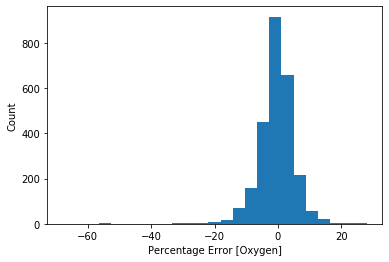

In [129]:
error = (test_labels - test_predictions)/test_labels*100
plt.hist(error, bins = 25)
plt.xlabel("Percentage Error [Oxygen]")
_ = plt.ylabel("Count")

In [36]:
## Save model
model.save('../data/saved_models/oxygen_model.h5')

## Load Model

In [7]:
model = keras.models.load_model('../data/saved_models/oxygen_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 5,137
Trainable params: 5,137
Non-trainable params: 0
_________________________________________________________________


In [9]:
test_predictions = model.predict(test_dataset).flatten()
error = test_predictions - test_labels

In [10]:
np.percentile(error, [2.5, 5, 95, 97.5])

array([-22.19529938, -16.60290347,  18.6556673 ,  23.59064091])

## Application: Predict based on Moorning data

In [20]:
import xarray as xr
import matplotlib.pyplot as plt

In [12]:
# Load PH100 Mooring data
wqm_ds = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_OZ_20100504_PH100_FV01_DOX2-aggregated-timeseries_END-20170828_C-20190819.nc') 

In [13]:
wqm_ds

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 33, OBSERVATION: 12073463)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    DOX2                      (OBSERVATION) float32 ...
    DOX2_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S256

In [10]:
# Nominal depth location of WQM sensors
np.unique(wqm_ds.NOMINAL_DEPTH.values)

array([15. , 15.5, 24. ], dtype=float32)

In [14]:
# Drop unecessary variables and export to dataframe
wqm_ds = wqm_ds.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [15]:
# filter out bad quality data 
wqm_ds = wqm_ds.where(np.logical_and(wqm_ds.DOX2_quality_control > 0, wqm_ds.DOX2_quality_control < 3), drop = True)

In [16]:
wqm_ds = wqm_ds.where(np.logical_and(wqm_ds.PRES_REL_quality_control > 0, wqm_ds.PRES_REL_quality_control < 3), drop = True)

In [17]:
# create pd dataframe from scratch
data  = {'TIME': wqm_ds.TIME.values,
         'DOX2': wqm_ds.DOX2.values,
         'PRES': wqm_ds.PRES_REL.values}

wqm_df = pd.DataFrame(data, columns = ['TIME','DOX2','PRES'])
# set TIME as the indexing variable
wqm_df = wqm_df.set_index('TIME')

In [25]:
wqm_df

,DOX2,PRES
TIME,,
2010-05-04 02:00:00.000003328,191.253952,28.760000
2010-05-04 02:00:01.000007936,191.167465,28.799999
2010-05-04 02:00:02.000002560,191.140900,28.840000
2010-05-04 02:00:03.000007168,191.029449,28.870001
2010-05-04 02:00:04.000001792,191.110626,28.870001
...,...,...
2017-08-27 18:30:19.000000768,212.614594,17.709999
2017-08-27 18:30:20.000005632,212.614273,17.830000
2017-08-27 18:30:21.000000000,212.701523,17.910000


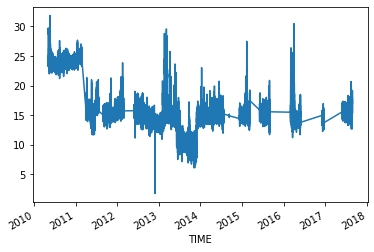

In [26]:
# Plot PRES over TIME
wqm_df.PRES.plot()

In [28]:
# save maximum pressure value for subsetting temperature later
max_pres = wqm_df.PRES.max()

In [29]:
# Bin data by pressure and hour:
# define pressure bins and labels for each bin
bins = np.linspace(0, 32, 17)
labs = np.linspace(1,31,16)

In [30]:
# create a column with pressure bin labels
wqm_df['PRES_BIN'] = pd.cut(wqm_df.PRES, bins = bins, labels = labs)

In [33]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
wqm_df = wqm_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'

In [36]:
wqm_df

DOX2
PRES_BIN TIME                           
1.0      2012-11-28 22:00:00  219.715591
3.0      2012-11-28 22:00:00  219.631363
7.0      2013-06-15 07:00:00  205.350891
         2013-06-15 08:00:00  205.339203
         2013-06-15 21:00:00  208.561523
...                                  ...
31.0     2010-05-21 10:00:00  210.213242
         2010-05-21 11:00:00  210.027222
         2010-05-21 12:00:00  209.906219
         2016-04-01 05:00:00  161.294037
         2016-04-01 06:00:00  162.787338

[62732 rows x 1 columns]

Text(0.5, 1.0, 'DOX2 concentration as 15dbar depth')

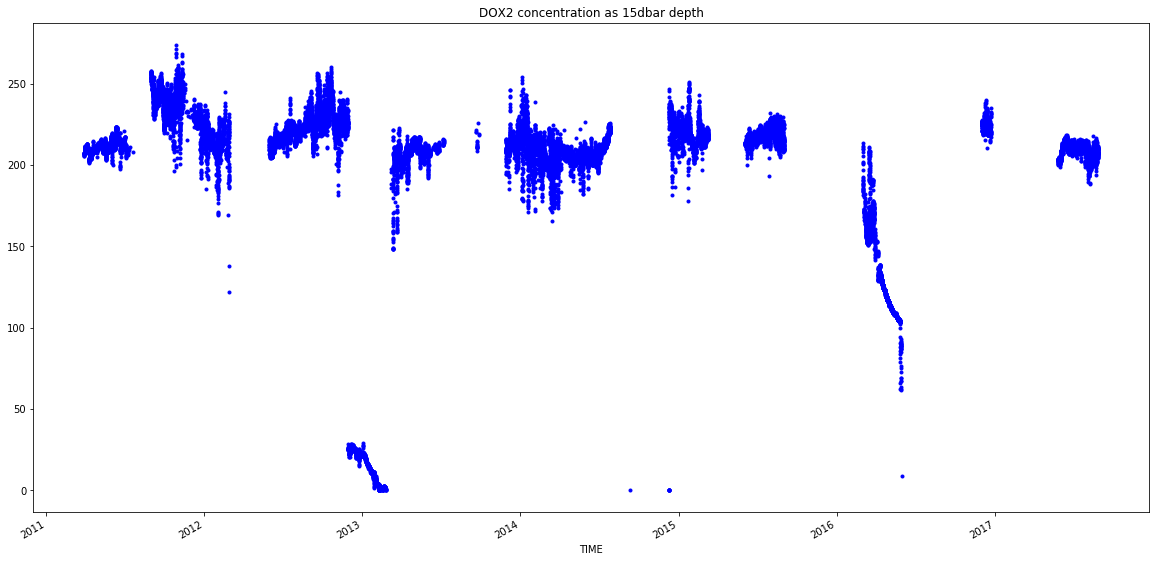

In [35]:
wqm_df.xs(15).DOX2.plot(style=['.b'],figsize=(20,10))
plt.title('DOX2 concentration as 15dbar depth')

### Temperature data 

In [37]:
temp = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_TZ_20091029_PH100_FV01_TEMP-aggregated-timeseries_END-20190612_C-20190819.nc')

In [38]:
temp

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 688, OBSERVATION: 25570235)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S25

In [39]:
# Nominal depth of temp instruments to compare with WQM instruments
np.unique(temp.NOMINAL_DEPTH.values)

array([ 15. ,  15.5,  16. ,  24. ,  32. ,  40. ,  48. ,  56. ,  64. ,
        72. ,  80. ,  88. ,  96. , 104. , 109.5, 110. ], dtype=float32)

In [40]:
temp = temp.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [41]:
temp = temp.where(np.logical_and(temp.TEMP_quality_control > 0, temp.TEMP_quality_control < 3), drop = True)

In [42]:
temp = temp.where(np.logical_and(temp.PRES_REL_quality_control > 0, temp.PRES_REL_quality_control < 3), drop = True) 

In [43]:
# create pd dataframe from scratch
data  = {'TIME': temp.TIME.values,
         'TEMP': temp.TEMP.values,
         'PRES': temp.PRES_REL.values}

temp_df= pd.DataFrame(data, columns = ['TIME','TEMP','PRES'])
# set TIME as the indexing variable
temp_df = temp_df.set_index('TIME')

In [44]:
# subset to the same dates water quality measurements
temp_df = temp_df.loc['2010-05-04 02':'2017-8-27 18']

In [45]:
# subset to same pressure range as WQM
temp_df = temp_df.where(temp_df.PRES <= max_pres).dropna()

In [29]:
# temp_df = temp_df.loc[~temp_df.index.duplicated()]

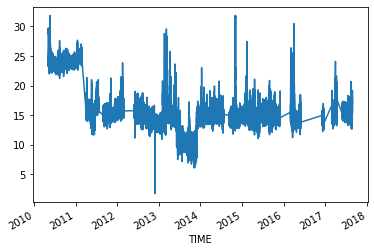

In [46]:
# Plot PRES over TIME
# Because of extra instruments (see NOMINAL_DEPTH vals), there are more pressure vals here compared to WQM
temp_df.PRES.plot()

In [47]:
# Bin data by pressure and hour:
# define pressure bins and labels for each bin
bins = np.linspace(0, 32, 17)
labs = np.linspace(1,31,16)

In [48]:
# create a column with pressure bin labels
temp_df['PRES_BIN'] = pd.cut(temp_df.PRES, bins = bins, labels = labs)

In [49]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
temp_df = temp_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

In [50]:
temp_df

TEMP
PRES_BIN TIME                          
1.0      2012-11-28 22:00:00  20.759911
3.0      2012-11-28 22:00:00  20.770100
7.0      2013-06-15 07:00:00  19.003767
         2013-06-15 08:00:00  18.982601
         2013-06-15 21:00:00  18.965900
...                                 ...
31.0     2014-11-04 08:00:00  19.540016
         2014-11-04 09:00:00  19.641979
         2014-11-04 10:00:00  19.633989
         2016-04-01 05:00:00  24.785011
         2016-04-01 06:00:00  24.770300

[75665 rows x 1 columns]

In [35]:
wqm_df

DOX2
PRES_BIN TIME                           
1.0      2012-11-28 22:00:00  219.715591
3.0      2012-11-28 22:00:00  219.631363
7.0      2013-06-15 07:00:00  205.350891
         2013-06-15 08:00:00  205.339203
         2013-06-15 21:00:00  208.561523
...                                  ...
31.0     2010-05-21 10:00:00  210.213242
         2010-05-21 11:00:00  210.027222
         2010-05-21 12:00:00  209.906219
         2016-04-01 05:00:00  161.294037
         2016-04-01 06:00:00  162.787338

[62732 rows x 1 columns]

In [51]:
# Join wqm_df and temp_df
mooring_df = wqm_df.join(temp_df, how='inner')

In [52]:
mooring_df

DOX2       TEMP
PRES_BIN TIME                                      
1.0      2012-11-28 22:00:00  219.715591  20.759911
3.0      2012-11-28 22:00:00  219.631363  20.770100
7.0      2013-06-15 07:00:00  205.350891  19.003767
         2013-06-15 08:00:00  205.339203  18.982601
         2013-06-15 21:00:00  208.561523  18.965900
...                                  ...        ...
31.0     2010-05-21 10:00:00  210.213242  22.698212
         2010-05-21 11:00:00  210.027222  22.679289
         2010-05-21 12:00:00  209.906219  22.679312
         2016-04-01 05:00:00  161.294037  24.785011
         2016-04-01 06:00:00  162.787338  24.770300

[62732 rows x 2 columns]

### Salinity data

In [53]:
psal = xr.open_dataset('/srv/scratch/z3289452/OceanDataScience/Mooring/PH100/IMOS_ANMN-NSW_SZ_20100504_PH100_FV01_PSAL-aggregated-timeseries_END-20190612_C-20190822.nc')

In [54]:
psal

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 50, OBSERVATION: 12502147)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    PSAL                      (OBSERVATION) float32 ...
    PSAL_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S256

In [55]:
# Nominal depth of temp instruments to compare with WQM instruments
np.unique(psal.NOMINAL_DEPTH.values)

array([ 15. ,  15.5,  24. , 104. ], dtype=float32)

In [56]:
psal = psal.drop(['DEPTH','DEPTH_quality_control','PRES','PRES_quality_control','instrument_index','instrument_id','source_file'])

In [57]:
psal = psal.where(np.logical_and(psal.PSAL_quality_control > 0, psal.PSAL_quality_control < 3), drop = True)

In [58]:
psal = psal.where(np.logical_and(psal.PRES_REL_quality_control > 0, psal.PRES_REL_quality_control < 3), drop = True) 

In [59]:
# create pd dataframe from scratch
data  = {'TIME': psal.TIME.values,
         'PSAL': psal.PSAL.values,
         'PRES': psal.PRES_REL.values}

psal_df= pd.DataFrame(data, columns = ['TIME','PSAL','PRES'])
# set TIME as the indexing variable
psal_df = psal_df.set_index('TIME')

In [60]:
# subset to the same dates water quality measurements
psal_df = psal_df.loc['2010-05-04 02':'2017-8-27 18']

In [61]:
# subset to same pressure range as WQM
psal_df = psal_df.where(psal_df.PRES <= max_pres).dropna()

In [64]:
# temp_df = temp_df.loc[~temp_df.index.duplicated()]

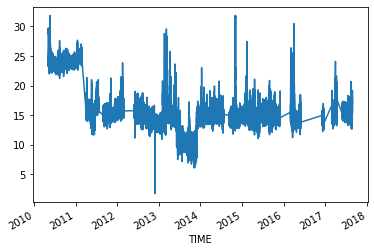

In [105]:
# Plot PRES over TIME
# Because of extra instruments (see NOMINAL_DEPTH vals), there are more pressure vals here compared to WQM
psal_df.PRES.plot()

In [62]:
# Bin data by pressure and hour:
# define pressure bins and labels for each bin
bins = np.linspace(0, 32, 17)
labs = np.linspace(1,31,16)

In [63]:
# create a column with pressure bin labels
psal_df['PRES_BIN'] = pd.cut(psal_df.PRES, bins = bins, labels = labs)

In [64]:
# First groupby PRES_BIN column, then resample each group on hourly intervals and mean each resulting bin
# drop unncessary columns and nan rows after
psal_df = psal_df.groupby('PRES_BIN').resample('1H').mean().drop(columns=['PRES','PRES_BIN']).dropna()

In [65]:
psal_df

PSAL
PRES_BIN TIME                          
1.0      2012-11-28 22:00:00  35.461388
3.0      2012-11-28 22:00:00  35.460751
7.0      2013-06-15 07:00:00  35.462334
         2013-06-15 08:00:00  35.463001
         2013-06-15 21:00:00  35.501999
...                                 ...
31.0     2014-11-04 08:00:00  35.632832
         2014-11-04 09:00:00  35.634396
         2014-11-04 10:00:00  35.633755
         2016-04-01 05:00:00  35.544964
         2016-04-01 06:00:00  35.544453

[75665 rows x 1 columns]

In [66]:
# Join with mooring_df
mooring_df = mooring_df.join(psal_df, how="inner")

In [67]:
mooring_df

DOX2       TEMP       PSAL
PRES_BIN TIME                                                 
1.0      2012-11-28 22:00:00  219.715591  20.759911  35.461388
3.0      2012-11-28 22:00:00  219.631363  20.770100  35.460751
7.0      2013-06-15 07:00:00  205.350891  19.003767  35.462334
         2013-06-15 08:00:00  205.339203  18.982601  35.463001
         2013-06-15 21:00:00  208.561523  18.965900  35.501999
...                                  ...        ...        ...
31.0     2010-05-21 10:00:00  210.213242  22.698212  35.327530
         2010-05-21 11:00:00  210.027222  22.679289  35.324860
         2010-05-21 12:00:00  209.906219  22.679312  35.319817
         2016-04-01 05:00:00  161.294037  24.785011  35.544964
         2016-04-01 06:00:00  162.787338  24.770300  35.544453

[62732 rows x 3 columns]

In [68]:
# reset indices and split TIME into YEAR YDAY and HOUR
mooring_df = mooring_df.reset_index()

In [69]:
import datetime

In [70]:
mooring_df['Year'] = mooring_df.TIME.dt.year
mooring_df['Yday'] = mooring_df.TIME.dt.dayofyear#pd.to_numeric(mooring_df.TIME.dt.strftime('%j'))
mooring_df['Hour'] = mooring_df.TIME.dt.hour

In [71]:
mooring_df.rename(columns={'PRES_BIN': 'PRESSURE', 'DOX2': 'OXYGEN_VALUE', 'TEMP': 'TEMPERATURE_VALUE', 'PSAL': 'SALINITY_VALUE'}, inplace=True)

In [161]:
# Normalise columns for prediction, similar to training data

,PRESSURE,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour
0,1.0,2012-11-28 22:00:00,219.715591,20.759911,35.461388,2012,333,22
1,3.0,2012-11-28 22:00:00,219.631363,20.770100,35.460751,2012,333,22
2,7.0,2013-06-15 07:00:00,205.350891,19.003767,35.462334,2013,166,7
3,7.0,2013-06-15 08:00:00,205.339203,18.982601,35.463001,2013,166,8
4,7.0,2013-06-15 21:00:00,208.561523,18.965900,35.501999,2013,166,21
...,...,...,...,...,...,...,...,...
62727,31.0,2010-05-21 10:00:00,210.213242,22.698212,35.327530,2010,141,10
62728,31.0,2010-05-21 11:00:00,210.027222,22.679289,35.324860,2010,141,11
62729,31.0,2010-05-21 12:00:00,209.906219,22.679312,35.319817,2010,141,12
62730,31.0,2016-04-01 05:00:00,161.294037,24.785011,35.544964,2016,92,5


In [72]:
import pickle

In [73]:
pickle_in = open("../data/standardisation_oxygen.pickle", "rb")
oxygen_stats = pickle.load(pickle_in)
oxygen_stats

,count,mean,std,min,25%,50%,75%,max
Year,12970.0,1970.413030,8.419602,1953.000,1964.00000,1971.00,1977.00,1985.000
Yday,12970.0,183.796530,105.020247,1.000,92.00000,187.00,275.00,365.000
Hour,12970.0,0.028373,0.807359,0.000,0.00000,0.00,0.00,23.000
PRESSURE,12970.0,47.623531,41.024090,0.000,20.00000,40.00,70.00,300.000
TEMPERATURE_VALUE,12970.0,17.498877,2.411700,10.110,15.75925,17.24,19.05,25.500
TEMPERATURE_QC_FLAG,12970.0,0.000000,0.000000,0.000,0.00000,0.00,0.00,0.000
SALINITY_VALUE,12970.0,35.461692,0.164354,31.924,35.38600,35.48,35.56,35.967
SALINITY_QC_FLAG,12970.0,0.000000,0.000000,0.000,0.00000,0.00,0.00,0.000
OXYGEN_VALUE,12970.0,0.000000,1.000000,109.900,199.69000,222.92,234.98,324.320
OXYGEN_QC_FLAG,12970.0,0.000000,0.000000,0.000,0.00000,0.00,0.00,0.000


In [74]:
oxygen_stats.loc['TEMPERATURE_VALUE','mean']

17.498876792598303

In [75]:
mooring_df.TEMPERATURE_VALUE =(mooring_df.TEMPERATURE_VALUE - oxygen_stats.loc['TEMPERATURE_VALUE','mean'])/oxygen_stats.loc['TEMPERATURE_VALUE','std']
mooring_df.SALINITY_VALUE =(mooring_df.SALINITY_VALUE - oxygen_stats.loc['SALINITY_VALUE','mean'])/oxygen_stats.loc['SALINITY_VALUE','std']
mooring_df.PRESSURE =(mooring_df.PRESSURE - oxygen_stats.loc['PRESSURE','mean'])/oxygen_stats.loc['PRESSURE','std']
mooring_df.Year =(mooring_df.Year - oxygen_stats.loc['Year','mean'])/oxygen_stats.loc['Year','std']
mooring_df.Yday =(mooring_df.Yday - oxygen_stats.loc['Yday','mean'])/oxygen_stats.loc['Yday','std']
mooring_df.Hour =(mooring_df.Hour - oxygen_stats.loc['Hour','mean'])/oxygen_stats.loc['Hour','std']

In [76]:
mooring_df

,PRESSURE,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour
0,-1.136492,2012-11-28 22:00:00,219.715591,1.352172,-0.001857,4.939304,1.420711,27.214206
1,-1.087740,2012-11-28 22:00:00,219.631363,1.356397,-0.005733,4.939304,1.420711,27.214206
2,-0.990236,2013-06-15 07:00:00,205.350891,0.623996,0.003899,5.058074,-0.169458,8.635104
3,-0.990236,2013-06-15 08:00:00,205.339203,0.615219,0.007961,5.058074,-0.169458,9.873711
4,-0.990236,2013-06-15 21:00:00,208.561523,0.608294,0.245240,5.058074,-0.169458,25.975600
...,...,...,...,...,...,...,...,...
62727,-0.405214,2010-05-21 10:00:00,210.213242,2.155880,-0.816306,4.701763,-0.407507,12.350925
62728,-0.405214,2010-05-21 11:00:00,210.027222,2.148033,-0.832553,4.701763,-0.407507,13.589532
62729,-0.405214,2010-05-21 12:00:00,209.906219,2.148043,-0.863237,4.701763,-0.407507,14.828138
62730,-0.405214,2016-04-01 05:00:00,161.294037,3.021161,0.506657,5.414386,-0.874084,6.157891


## Prediction using ANN model

In [77]:
mooring_df['DOX2_predictions'] = model.predict(mooring_df[['Year','Yday','Hour','PRESSURE','TEMPERATURE_VALUE','SALINITY_VALUE']])
mooring_df['DOX2_error'] = mooring_df.OXYGEN_VALUE - mooring_df.DOX2_predictions

In [78]:
mooring_df

,PRESSURE,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour,DOX2_predictions,DOX2_error
0,-1.136492,2012-11-28 22:00:00,219.715591,1.352172,-0.001857,4.939304,1.420711,27.214206,191.269196,28.446396
1,-1.087740,2012-11-28 22:00:00,219.631363,1.356397,-0.005733,4.939304,1.420711,27.214206,190.373627,29.257736
2,-0.990236,2013-06-15 07:00:00,205.350891,0.623996,0.003899,5.058074,-0.169458,8.635104,112.922050,92.428841
3,-0.990236,2013-06-15 08:00:00,205.339203,0.615219,0.007961,5.058074,-0.169458,9.873711,117.785454,87.553749
4,-0.990236,2013-06-15 21:00:00,208.561523,0.608294,0.245240,5.058074,-0.169458,25.975600,246.425446,-37.863922
...,...,...,...,...,...,...,...,...,...,...
62727,-0.405214,2010-05-21 10:00:00,210.213242,2.155880,-0.816306,4.701763,-0.407507,12.350925,158.802689,51.410553
62728,-0.405214,2010-05-21 11:00:00,210.027222,2.148033,-0.832553,4.701763,-0.407507,13.589532,162.020569,48.006653
62729,-0.405214,2010-05-21 12:00:00,209.906219,2.148043,-0.863237,4.701763,-0.407507,14.828138,165.005417,44.900803
62730,-0.405214,2016-04-01 05:00:00,161.294037,3.021161,0.506657,5.414386,-0.874084,6.157891,147.765533,13.528503


(array([  147.,   466.,   763.,  2342.,  2929.,  7256., 15003., 18591.,
        13817.,  1418.]),
 array([-304.86722 , -256.50882 , -208.15042 , -159.79202 , -111.43362 ,
         -63.07522 ,  -14.716818,   33.641582,   81.999985,  130.35838 ,
         178.71678 ], dtype=float32),
 <a list of 10 Patch objects>)

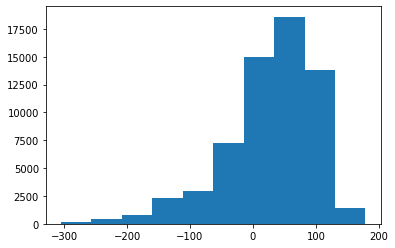

In [70]:
plt.hist(mooring_df['DOX2_error'])

In [136]:
mooring_df.TEMPERATURE_VALUE =(mooring_df.TEMPERATURE_VALUE * oxygen_stats.loc['TEMPERATURE_VALUE','std'])+oxygen_stats.loc['TEMPERATURE_VALUE','mean']
mooring_df.SALINITY_VALUE =(mooring_df.SALINITY_VALUE * oxygen_stats.loc['SALINITY_VALUE','std'])+oxygen_stats.loc['SALINITY_VALUE','mean']
# mooring_df.PRESSURE =(mooring_df.PRESSURE * oxygen_stats.loc['PRESSURE','std'])+oxygen_stats.loc['PRESSURE','mean']
mooring_df.Year =(mooring_df.Year * oxygen_stats.loc['Year','std'])+oxygen_stats.loc['Year','mean']
mooring_df.Yday =(mooring_df.Yday * oxygen_stats.loc['Yday','std'])+oxygen_stats.loc['Yday','mean']
mooring_df.Hour =(mooring_df.Hour * oxygen_stats.loc['Hour','std'])+oxygen_stats.loc['Hour','mean']

In [137]:
mooring_df

,PRESSURE,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour,DOX2_predictions,DOX2_error
0,1.0,2012-11-28 22:00:00,219.715591,20.759911,35.461388,2012.0,333.0,22.0,191.269196,28.446396
1,3.0,2012-11-28 22:00:00,219.631363,20.770100,35.460751,2012.0,333.0,22.0,190.373627,29.257736
2,7.0,2013-06-15 07:00:00,205.350891,19.003767,35.462334,2013.0,166.0,7.0,112.922050,92.428841
3,7.0,2013-06-15 08:00:00,205.339203,18.982601,35.463001,2013.0,166.0,8.0,117.785454,87.553749
4,7.0,2013-06-15 21:00:00,208.561523,18.965900,35.501999,2013.0,166.0,21.0,246.425446,-37.863922
...,...,...,...,...,...,...,...,...,...,...
62727,31.0,2010-05-21 10:00:00,210.213242,22.698212,35.327530,2010.0,141.0,10.0,158.802689,51.410553
62728,31.0,2010-05-21 11:00:00,210.027222,22.679289,35.324860,2010.0,141.0,11.0,162.020569,48.006653
62729,31.0,2010-05-21 12:00:00,209.906219,22.679312,35.319817,2010.0,141.0,12.0,165.005417,44.900803
62730,31.0,2016-04-01 05:00:00,161.294037,24.785011,35.544964,2016.0,92.0,5.0,147.765533,13.528503


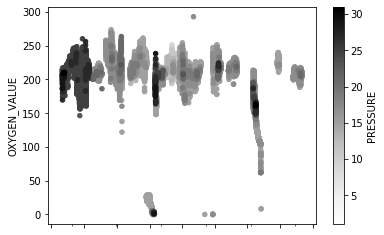

In [98]:
mooring_df.plot.scatter('TIME','OXYGEN_VALUE',c='PRESSURE')

In [99]:
mooring_df.groupby('PRESSURE').count()

,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour,DOX2_predictions,DOX2_error
PRESSURE,,,,,,,,,
1.0,1,1,1,1,1,1,1,1,1
3.0,1,1,1,1,1,1,1,1,1
7.0,189,189,189,189,189,189,189,189,189
9.0,3047,3047,3047,3047,3047,3047,3047,3047,3047
11.0,3382,3382,3382,3382,3382,3382,3382,3382,3382
13.0,8405,8405,8405,8405,8405,8405,8405,8405,8405
15.0,26249,26249,26249,26249,26249,26249,26249,26249,26249
17.0,9507,9507,9507,9507,9507,9507,9507,9507,9507
19.0,1071,1071,1071,1071,1071,1071,1071,1071,1071


In [138]:
plot_df = mooring_df.where((mooring_df.PRESSURE>13) & (mooring_df.PRESSURE<16)).dropna()
# mooring_df.where((mooring_df.PRESSURE==15.0)).dropna()

In [139]:
plot_df

,PRESSURE,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour,DOX2_predictions,DOX2_error
15025,15.0,2011-03-30 02:00:00,207.406555,23.874733,35.421001,2011.0,89.0,2.0,177.838867,29.567688
15026,15.0,2011-03-30 23:00:00,205.592316,24.032101,35.394669,2011.0,89.0,23.0,234.460815,-28.868500
15027,15.0,2011-03-31 00:00:00,205.822815,23.990505,35.395649,2011.0,90.0,0.0,301.231262,-95.408447
15028,15.0,2011-03-31 01:00:00,206.022751,23.955677,35.400547,2011.0,90.0,1.0,221.052155,-15.029404
15029,15.0,2011-03-31 02:00:00,206.452667,23.911592,35.403381,2011.0,90.0,2.0,178.483475,27.969193
...,...,...,...,...,...,...,...,...,...,...
41269,15.0,2017-08-27 13:00:00,209.932739,18.792896,35.667912,2017.0,239.0,13.0,145.746658,64.186081
41270,15.0,2017-08-27 14:00:00,210.159729,18.775326,35.667591,2017.0,239.0,14.0,154.523331,55.636398
41271,15.0,2017-08-27 15:00:00,210.691208,18.669523,35.669529,2017.0,239.0,15.0,162.241272,48.449936
41272,15.0,2017-08-27 16:00:00,211.089798,18.511110,35.671211,2017.0,239.0,16.0,169.491867,41.597931


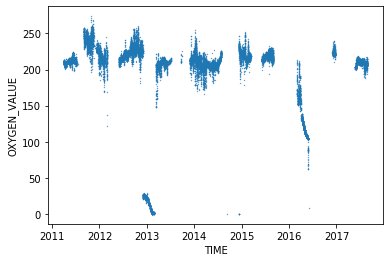

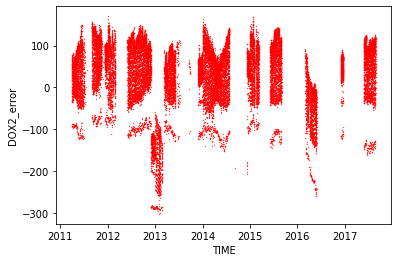

In [128]:
plot_df.plot.scatter('TIME','OXYGEN_VALUE',s=0.1)
plot_df.plot.scatter('TIME', 'DOX2_error',c='r',s=0.1)

In [159]:
temp = plot_df.where((mooring_df.DOX2_error < 20) & (mooring_df.DOX2_error > -20)).dropna()

In [160]:
temp

,PRESSURE,TIME,OXYGEN_VALUE,TEMPERATURE_VALUE,SALINITY_VALUE,Year,Yday,Hour,DOX2_predictions,DOX2_error
15028,15.0,2011-03-31 01:00:00,206.022751,23.955677,35.400547,2011.0,90.0,1.0,221.052155,-15.029404
15043,15.0,2011-03-31 16:00:00,207.307846,23.617336,35.422607,2011.0,90.0,16.0,190.914795,16.393051
15044,15.0,2011-03-31 17:00:00,207.345306,23.603033,35.425041,2011.0,90.0,17.0,198.152420,9.192886
15045,15.0,2011-03-31 18:00:00,207.629807,23.576160,35.428406,2011.0,90.0,18.0,205.724579,1.905228
15046,15.0,2011-03-31 19:00:00,207.436325,23.583130,35.427765,2011.0,90.0,19.0,212.975769,-5.539444
...,...,...,...,...,...,...,...,...,...,...
41241,15.0,2017-08-25 21:00:00,208.320831,17.795134,35.689640,2017.0,237.0,21.0,221.363037,-13.042206
41245,15.0,2017-08-26 01:00:00,207.603455,17.589165,35.678226,2017.0,238.0,1.0,205.405807,2.197647
41263,15.0,2017-08-26 19:00:00,204.377441,18.722832,35.766171,2017.0,238.0,19.0,191.928680,12.448761
41264,15.0,2017-08-26 20:00:00,205.087646,18.698603,35.762321,2017.0,238.0,20.0,206.633652,-1.546005


Text(0.5, 0, 'Temperature (degree Celsius)')

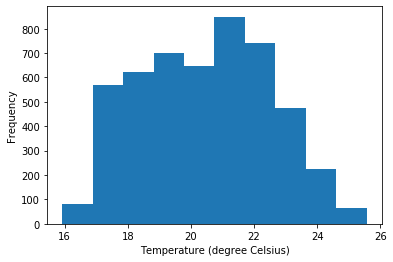

In [162]:
temp.TEMPERATURE_VALUE.plot.hist()
plt.xlabel('Temperature (degree Celsius)')

Text(0.5, 0, 'Salinity (g/L)')

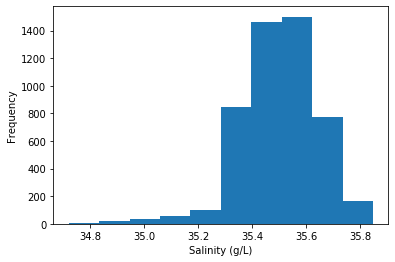

In [164]:
temp.SALINITY_VALUE.plot.hist()
plt.xlabel('Salinity (g/L)')

Text(0.5, 0, 'Day of year')

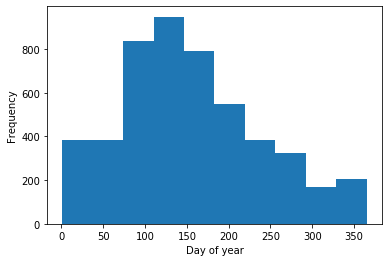

In [165]:
temp.Yday.plot.hist()
plt.xlabel('Day of year')

Text(0.5, 0, 'Hour')

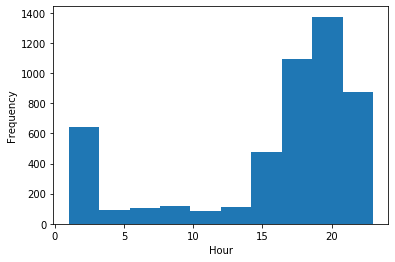

In [166]:
temp.Hour.plot.hist()
plt.xlabel('Hour')